# WMT of tendency terms - play with bin sizes
## CM2.6
## Table Of Contents: <a class="anchor" id="top"> </a>
* [Make histogram of each term](#first-bullet)
* [Save histograms](#second-bullet)

In [8]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
#options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster()
cluster.scale(30)
client = cluster.get_client()

In [2]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.ec2b3760fc684e59b826f2897d94fd16/status,


In [71]:
cluster.close()
client.close()

In [3]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
from fastjmd95 import jmd95numba, rho
import fastjmd95
import gcsfs
import xgcm

In [4]:
from intake import open_catalog

url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/GFDL_CM2.6.yaml"
cat = open_catalog(url)
ds  = cat["GFDL_CM2_6_control_ocean"].to_dask()
surf_ds  = cat["GFDL_CM2_6_control_ocean_surface"].to_dask()
coord  = cat["GFDL_CM2_6_grid"].to_dask()

/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/srv/conda/envs/notebook/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes

In [6]:
ds.mld.coords

Coordinates:
    geolat_t  (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * time      (time) object 2kB 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98

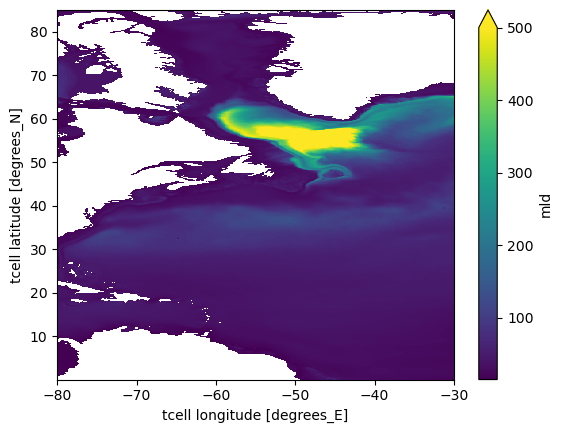

In [7]:
ds.mld.mean('time').sel(xt_ocean=slice(-80, -30), yt_ocean=slice(0,85)).plot(vmax=500)

In [2]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [31]:
tracers = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/tracer_tendencies.zarr'))
cab = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/cabbeling.zarr'))
rho_lap = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/rho_lap.zarr'))
rho_ds = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/rho_term.zarr'))

tendencies = xr.merge([tracers, cab, rho_lap])

In [25]:
tendencies

<xarray.Dataset>
Dimensions:    (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time       (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    geolat_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    SSS_lap    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    SST_lap    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    cabbeling  (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    rho_lap    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>

In [5]:
res = tendencies.rho_lap + tendencies.cabbeling - tendencies.SSS_lap - tendencies.SST_lap

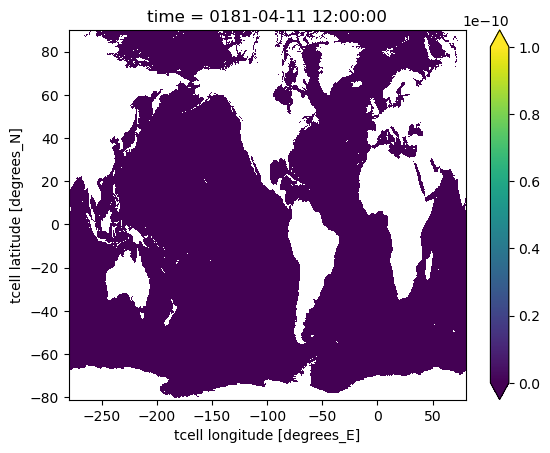

In [6]:
res.isel(time=100).plot(robust=True, vmin=1e-10);

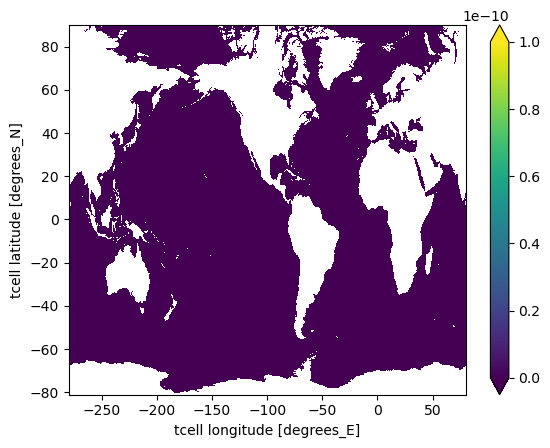

In [49]:
res.mean('time').plot(robust=True, vmin=1e-10);

# Mask by basin

In [7]:
!pip install git+https://github.com/mathause/regionmask.git

  Cloning https://github.com/mathause/regionmask.git to /tmp/pip-req-build-zyblqex1
  Running command git clone --filter=blob:none --quiet https://github.com/mathause/regionmask.git /tmp/pip-req-build-zyblqex1
  Resolved https://github.com/mathause/regionmask.git to commit 048e2bbee3b5e3ef945139b8a957e8406c4b06df
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for regionmask: filename=regionmask-0.9.0.post1.dev45+g048e2bb-py3-none-any.whl size=67327 sha256=1d407c7be2eb099481ade58ccc7748500c471abc57f9876ac7a92fb38825fe2c
  Stored in directory: /tmp/pip-ephem-wheel-cache-jivjtyzt/wheels/1a/62/0f/f392f37f9bd2d2d61b9a6b63de17bb421b3f7c2972b03c9934
Successfully built regionmask


In [8]:
!pip install git+https://github.com/jbusecke/xmip.git

  Cloning https://github.com/jbusecke/xmip.git to /tmp/pip-req-build-yiv9zfip
  Running command git clone --filter=blob:none --quiet https://github.com/jbusecke/xmip.git /tmp/pip-req-build-yiv9zfip
  Resolved https://github.com/jbusecke/xmip.git to commit 3bc0793f3bc7529a0e49da931e7d2465aa5eefd0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached xgcm-0.6.1-py3-none-any.whl (60 kB)
  Created wheel for xmip: filename=xmip-0.7.2.dev8+g3bc0793-py3-none-any.whl size=58754 sha256=798ac1b5b4701db3fb83ad71c7325efeaa756fd4256f672e3274b6d77d9ad2df
  Stored in directory: /tmp/pip-ephem-wheel-cache-skl967ig/wheels/14/81/1d/2382ef5c4df3bc79c5b5a3c37400af047e5a775a4b2cf79b42
Successfully built xmip
  Attempting uninstall: xgcm
    Found existing installation: xgcm 0.8.1
    Uninstalling xgcm-0.8.1:
      Successfully uninstalled xgcm-0.8.1
  Attempting uninstall: xmip
    Found existing installation: x

In [9]:
import regionmask  
from xmip.preprocessing import combined_preprocessing
from xmip.regionmask import merged_mask

<GeoAxes: >

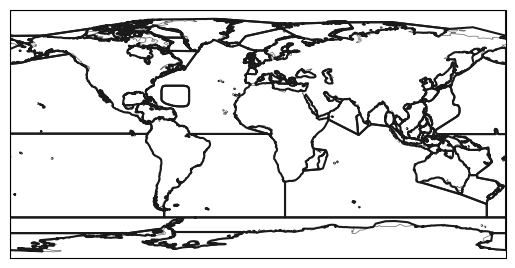

In [10]:
# load ocean basin data
basins = regionmask.defined_regions.natural_earth_v4_1_0.ocean_basins_50
basins.plot(add_ocean=False, add_label=False)

In [13]:
da = ds.temp.isel(time=0, st_ocean=0).squeeze()

In [14]:
da_renamed = da.rename({'geolat_t':'lat', 'geolon_t':'lon'}).load()

In [15]:
mask = merged_mask(basins, da_renamed)

/srv/conda/envs/notebook/lib/python3.10/site-packages/regionmask/core/mask.py:153: FutureWarning: Passing 'lon_name' and 'lat_name' is deprecated. Please pass the lon and lat coordinates direcly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/pygeos/io.py:523: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry


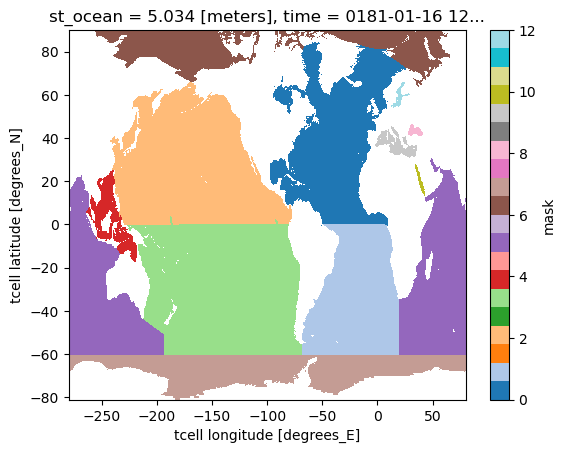

In [21]:
mask.plot(cmap='tab20');

In [16]:
#assign each region index value to basin name

north_atlantic_ocean = 0
south_atlantic_ocean = 1
north_pacific_ocean = 2
south_pacific_ocean = 3
south_china_seas = 4
indian_ocean = 5
arctic_ocean = 6
southern_ocean = 7
black_sea = 8
med_sea = 9
red_sea = 10
baltic_sea = 12 #no 11

In [17]:
def basin_selection(tend_term, basin):
    tendency_in_basin = tend_term.where(mask==basin)
    return tendency_in_basin

### Mixing part

In [18]:
tend = tendencies

In [19]:
all_tendencies = list(tend)

In [20]:
#Atlantic Ocean - going to add 'NATL' prefix after adding natl_ocean+nor_sea+lab_sea respective vars
natl_ocean = xr.merge([basin_selection(tend[var],
                                       north_atlantic_ocean).rename('NATL_' + var) for var in all_tendencies])
satl_ocean = xr.merge([basin_selection(tend[var], 
                                       south_atlantic_ocean).rename('SATL_' + var) for var in all_tendencies])

#Pacific Ocean
npac_ocean = xr.merge([basin_selection(tend[var], 
                                       north_pacific_ocean).rename('NPAC_' + var) for var in all_tendencies])
spac_ocean = xr.merge([basin_selection(tend[var], 
                                       south_pacific_ocean).rename('SPAC_' + var) for var in all_tendencies])

#Indian Ocean
ind_ocean = xr.merge([basin_selection(tend[var], indian_ocean).rename('IND_' + var) for var in all_tendencies])

#Arctic Ocean
arc_ocean = xr.merge([basin_selection(tend[var], arctic_ocean).rename('ARC_' + var) for var in all_tendencies])

#Southern Ocean
south_ocean = xr.merge([basin_selection(tend[var], 
                                        southern_ocean).rename('South_' + var) for var in all_tendencies])

# Run histograms

In [76]:
rmask = mask
#mask_bins = np.arange(rmask.min()-0.5, rmask.max()+0.5)
mask_bins = np.array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5, 12.5, 99.5])
rho = rho_ds.rho # tendencies.rho
delta_rho = 0.1
rho_bins = np.arange(1015, 1035, delta_rho)
delta_rho_05 = 0.05
rho_bins_05 = np.arange(1015, 1035, delta_rho_05)
delta_rho_2 = 0.2
rho_bins_2 = np.arange(1015, 1035, delta_rho_2)

In [27]:
avg_mld = ds.mld.mean('time').compute()
weights = coord.area_t*avg_mld

### Mixing part (histograms)

## Testing original spacing of 0.1

In [28]:
from xhistogram.xarray import histogram
def histogram_function(ds, prefix, ocean, variable):
    """Generalized xhistogram's histogram function 
    for mixing tendency terms"""
    hist = histogram(rho.rename('rho0'), bins=[rho_bins],
                     weights=(ds[prefix+variable].fillna(0.)*(avg_mld*coord.area_t).where(mask==ocean).fillna(0.)),
                     dim=['xt_ocean', 'yt_ocean'])
    return hist / delta_rho

In [29]:
#mixing components
natl_hist = xr.merge([histogram_function(natl_ocean, 'NATL_', north_atlantic_ocean,
                                         var).rename('OMEGA_' + var) for var in all_tendencies])
satl_hist = xr.merge([histogram_function(satl_ocean, 'SATL_', south_atlantic_ocean,
                                         var).rename('OMEGA_' + var) for var in all_tendencies])
npac_hist = xr.merge([histogram_function(npac_ocean, 'NPAC_', north_pacific_ocean,
                                         var).rename('OMEGA_' + var) for var in all_tendencies])
spac_hist = xr.merge([histogram_function(spac_ocean, 'SPAC_', south_pacific_ocean,
                                         var).rename('OMEGA_' + var) for var in all_tendencies])
ind_hist = xr.merge([histogram_function(ind_ocean, 'IND_', indian_ocean,
                                        var).rename('OMEGA_' + var) for var in all_tendencies])
arc_hist = xr.merge([histogram_function(arc_ocean, 'ARC_', arctic_ocean,
                                        var).rename('OMEGA_' + var) for var in all_tendencies])
south_hist = xr.merge([histogram_function(south_ocean, 'South_', southern_ocean,
                                          var).rename('OMEGA_' + var) for var in all_tendencies])

In [39]:
res_natl = ((natl_hist.OMEGA_rho_lap - natl_hist.OMEGA_SSS_lap - 
             natl_hist.OMEGA_SST_lap + natl_hist.OMEGA_cabbeling)/1e6)

In [41]:
res_npac = ((npac_hist.OMEGA_rho_lap - npac_hist.OMEGA_SSS_lap - 
             npac_hist.OMEGA_SST_lap + npac_hist.OMEGA_cabbeling)/1e6)

In [42]:
res_arc = ((arc_hist.OMEGA_rho_lap - arc_hist.OMEGA_SSS_lap - 
             arc_hist.OMEGA_SST_lap + arc_hist.OMEGA_cabbeling)/1e6)

In [43]:
res_south = ((south_hist.OMEGA_rho_lap - south_hist.OMEGA_SSS_lap - 
             south_hist.OMEGA_SST_lap + south_hist.OMEGA_cabbeling)/1e6)

In [61]:
res_ds = xr.merge([res_natl.rename('natl'), res_npac.rename('npac'), 
                  res_arc.rename('arc'), res_south.rename('south')])

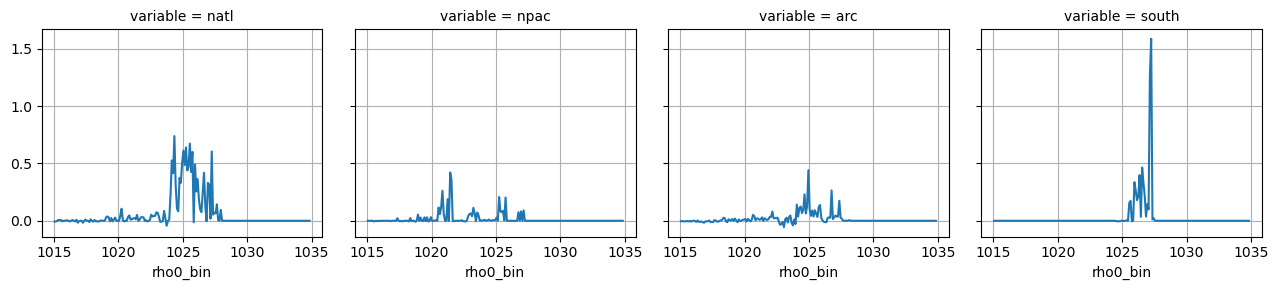

In [52]:
plt.rcParams['axes.grid'] = True
res_ds.isel(time=100).to_array().plot.line(col='variable', col_wrap=4);

## Testing spacing of 0.05

In [53]:
from xhistogram.xarray import histogram
def histogram_function(ds, prefix, ocean, variable):
    """Generalized xhistogram's histogram function 
    for mixing tendency terms"""
    hist = histogram(rho.rename('rho0'), bins=[rho_bins],
                     weights=(ds[prefix+variable].fillna(0.)*(avg_mld*coord.area_t).where(mask==ocean).fillna(0.)),
                     dim=['xt_ocean', 'yt_ocean'])
    return hist / delta_rho_05

In [54]:
#mixing components
natl_hist_05 = xr.merge([histogram_function(natl_ocean, 'NATL_', north_atlantic_ocean,
                                         var).rename('OMEGA_' + var) for var in all_tendencies])
satl_hist_05 = xr.merge([histogram_function(satl_ocean, 'SATL_', south_atlantic_ocean,
                                         var).rename('OMEGA_' + var) for var in all_tendencies])
npac_hist_05 = xr.merge([histogram_function(npac_ocean, 'NPAC_', north_pacific_ocean,
                                         var).rename('OMEGA_' + var) for var in all_tendencies])
spac_hist_05 = xr.merge([histogram_function(spac_ocean, 'SPAC_', south_pacific_ocean,
                                         var).rename('OMEGA_' + var) for var in all_tendencies])
ind_hist_05 = xr.merge([histogram_function(ind_ocean, 'IND_', indian_ocean,
                                        var).rename('OMEGA_' + var) for var in all_tendencies])
arc_hist_05 = xr.merge([histogram_function(arc_ocean, 'ARC_', arctic_ocean,
                                        var).rename('OMEGA_' + var) for var in all_tendencies])
south_hist_05 = xr.merge([histogram_function(south_ocean, 'South_', southern_ocean,
                                          var).rename('OMEGA_' + var) for var in all_tendencies])

In [55]:
res_natl_05 = ((natl_hist_05.OMEGA_rho_lap - natl_hist_05.OMEGA_SSS_lap - 
             natl_hist_05.OMEGA_SST_lap + natl_hist_05.OMEGA_cabbeling)/1e6)

In [56]:
res_npac_05 = ((npac_hist_05.OMEGA_rho_lap - npac_hist_05.OMEGA_SSS_lap - 
             npac_hist_05.OMEGA_SST_lap + npac_hist_05.OMEGA_cabbeling)/1e6)

In [57]:
res_arc_05 = ((arc_hist_05.OMEGA_rho_lap - arc_hist_05.OMEGA_SSS_lap - 
             arc_hist_05.OMEGA_SST_lap + arc_hist_05.OMEGA_cabbeling)/1e6)

In [58]:
res_south_05 = ((south_hist_05.OMEGA_rho_lap - south_hist_05.OMEGA_SSS_lap - 
             south_hist_05.OMEGA_SST_lap + south_hist_05.OMEGA_cabbeling)/1e6)

In [60]:
res_ds_05 = xr.merge([res_natl_05.rename('natl'), res_npac_05.rename('npac'), 
                  res_arc_05.rename('arc'), res_south_05.rename('south')])

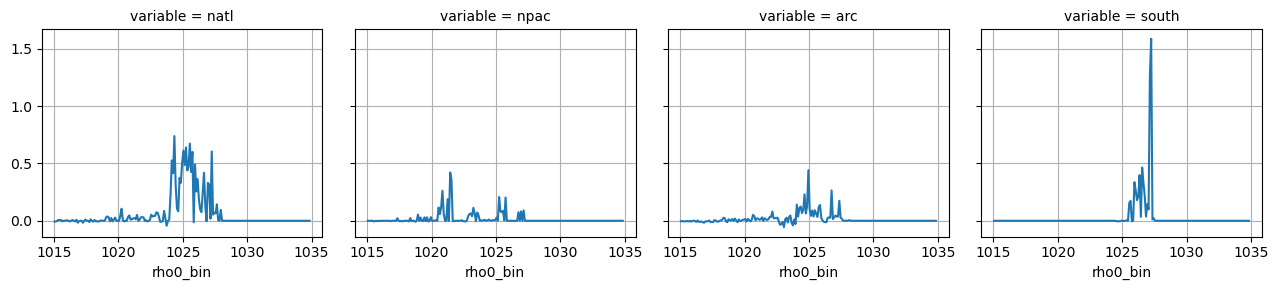

In [52]:
plt.rcParams['axes.grid'] = True
res_ds.isel(time=100).to_array().plot.line(col='variable', col_wrap=4);

## Testing spacing of 0.01

In [68]:
from xhistogram.xarray import histogram
def histogram_function(ds, prefix, ocean, variable):
    """Generalized xhistogram's histogram function 
    for mixing tendency terms"""
    hist = histogram(rho.rename('rho0'), bins=[rho_bins_01],
                     weights=(ds[prefix+variable].fillna(0.)*(avg_mld*coord.area_t).where(mask==ocean).fillna(0.)),
                     dim=['xt_ocean', 'yt_ocean'])
    return hist / delta_rho_01

In [69]:
#mixing components
natl_hist_01 = xr.merge([histogram_function(natl_ocean, 'NATL_', north_atlantic_ocean,
                                         var).rename('OMEGA_' + var) for var in all_tendencies])
satl_hist_01 = xr.merge([histogram_function(satl_ocean, 'SATL_', south_atlantic_ocean,
                                         var).rename('OMEGA_' + var) for var in all_tendencies])
npac_hist_01 = xr.merge([histogram_function(npac_ocean, 'NPAC_', north_pacific_ocean,
                                         var).rename('OMEGA_' + var) for var in all_tendencies])
spac_hist_01 = xr.merge([histogram_function(spac_ocean, 'SPAC_', south_pacific_ocean,
                                         var).rename('OMEGA_' + var) for var in all_tendencies])
ind_hist_01 = xr.merge([histogram_function(ind_ocean, 'IND_', indian_ocean,
                                        var).rename('OMEGA_' + var) for var in all_tendencies])
arc_hist_01 = xr.merge([histogram_function(arc_ocean, 'ARC_', arctic_ocean,
                                        var).rename('OMEGA_' + var) for var in all_tendencies])
south_hist_01 = xr.merge([histogram_function(south_ocean, 'South_', southern_ocean,
                                          var).rename('OMEGA_' + var) for var in all_tendencies])

In [70]:
res_natl_01 = ((natl_hist_01.OMEGA_rho_lap - natl_hist_01.OMEGA_SSS_lap - 
             natl_hist_01.OMEGA_SST_lap + natl_hist_01.OMEGA_cabbeling)/1e6)

In [71]:
res_npac_01 = ((npac_hist_01.OMEGA_rho_lap - npac_hist_01.OMEGA_SSS_lap - 
             npac_hist_01.OMEGA_SST_lap + npac_hist_01.OMEGA_cabbeling)/1e6)

In [72]:
res_arc_01 = ((arc_hist_01.OMEGA_rho_lap - arc_hist_01.OMEGA_SSS_lap - 
             arc_hist_01.OMEGA_SST_lap + arc_hist_01.OMEGA_cabbeling)/1e6)

In [73]:
res_south_01 = ((south_hist_01.OMEGA_rho_lap - south_hist_01.OMEGA_SSS_lap - 
             south_hist_01.OMEGA_SST_lap + south_hist_01.OMEGA_cabbeling)/1e6)

In [74]:
res_ds_01 = xr.merge([res_natl_01.rename('natl'), res_npac_01.rename('npac'), 
                  res_arc_01.rename('arc'), res_south_01.rename('south')])

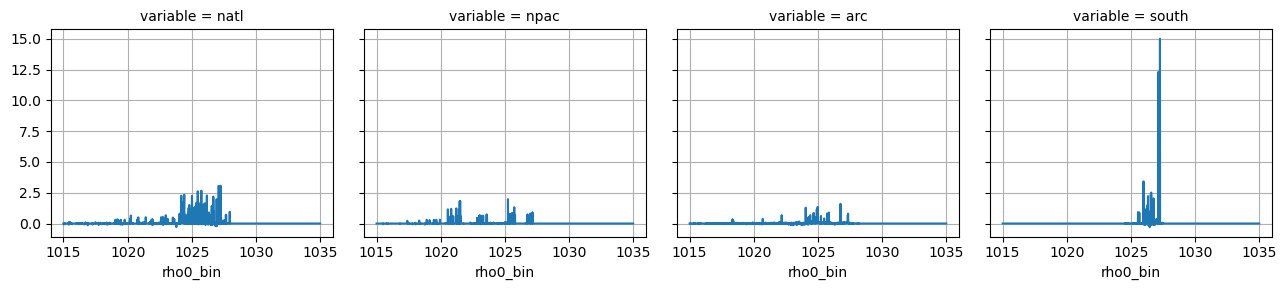

In [75]:
plt.rcParams['axes.grid'] = True
res_ds_01.isel(time=100).to_array().plot.line(col='variable', col_wrap=4);

## Testing spacing of 0.2

In [77]:
from xhistogram.xarray import histogram
def histogram_function(ds, prefix, ocean, variable):
    """Generalized xhistogram's histogram function 
    for mixing tendency terms"""
    hist = histogram(rho.rename('rho0'), bins=[rho_bins_2],
                     weights=(ds[prefix+variable].fillna(0.)*(avg_mld*coord.area_t).where(mask==ocean).fillna(0.)),
                     dim=['xt_ocean', 'yt_ocean'])
    return hist / delta_rho_2

In [78]:
#mixing components
natl_hist_2 = xr.merge([histogram_function(natl_ocean, 'NATL_', north_atlantic_ocean,
                                         var).rename('OMEGA_' + var) for var in all_tendencies])
satl_hist_2 = xr.merge([histogram_function(satl_ocean, 'SATL_', south_atlantic_ocean,
                                         var).rename('OMEGA_' + var) for var in all_tendencies])
npac_hist_2 = xr.merge([histogram_function(npac_ocean, 'NPAC_', north_pacific_ocean,
                                         var).rename('OMEGA_' + var) for var in all_tendencies])
spac_hist_2 = xr.merge([histogram_function(spac_ocean, 'SPAC_', south_pacific_ocean,
                                         var).rename('OMEGA_' + var) for var in all_tendencies])
ind_hist_2 = xr.merge([histogram_function(ind_ocean, 'IND_', indian_ocean,
                                        var).rename('OMEGA_' + var) for var in all_tendencies])
arc_hist_2 = xr.merge([histogram_function(arc_ocean, 'ARC_', arctic_ocean,
                                        var).rename('OMEGA_' + var) for var in all_tendencies])
south_hist_2 = xr.merge([histogram_function(south_ocean, 'South_', southern_ocean,
                                          var).rename('OMEGA_' + var) for var in all_tendencies])

In [79]:
res_natl_2 = ((natl_hist_2.OMEGA_rho_lap - natl_hist_2.OMEGA_SSS_lap - 
             natl_hist_2.OMEGA_SST_lap + natl_hist_2.OMEGA_cabbeling)/1e6)

In [80]:
res_npac_2 = ((npac_hist_2.OMEGA_rho_lap - npac_hist_2.OMEGA_SSS_lap - 
             npac_hist_2.OMEGA_SST_lap + npac_hist_2.OMEGA_cabbeling)/1e6)

In [81]:
res_arc_2 = ((arc_hist_2.OMEGA_rho_lap - arc_hist_2.OMEGA_SSS_lap - 
             arc_hist_2.OMEGA_SST_lap + arc_hist_2.OMEGA_cabbeling)/1e6)

In [82]:
res_south_2 = ((south_hist_2.OMEGA_rho_lap - south_hist_2.OMEGA_SSS_lap - 
             south_hist_2.OMEGA_SST_lap + south_hist_2.OMEGA_cabbeling)/1e6)

In [84]:
res_ds_2 = xr.merge([res_natl_2.rename('natl'), res_npac_2.rename('npac'), 
                  res_arc_2.rename('arc'), res_south_2.rename('south')])

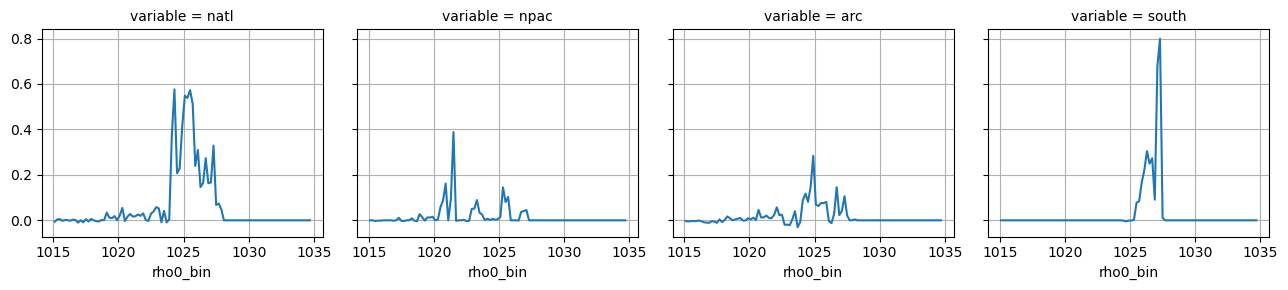

In [85]:
plt.rcParams['axes.grid'] = True
res_ds_2.isel(time=100).to_array().plot.line(col='variable', col_wrap=4);

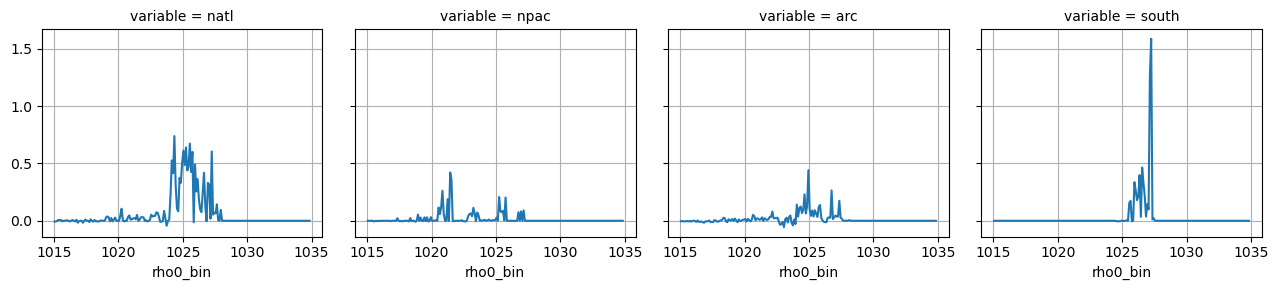

In [52]:
plt.rcParams['axes.grid'] = True
res_ds.isel(time=100).to_array().plot.line(col='variable', col_wrap=4);